# Midterm
# Name:
# Student ID number: X <font color = 'green'> (XX / 100) </font>

## General comments 
This Midterm integrates knowledge and skills acquired in the first half of the semester, especially in the 6 Assignments. You are allowed to use any document and source on your computer and look up documents on the internet. **You or not allowed to share documents, or communicate in any other way with people in real time during the midterm.** To finish the midterm in the alloted time, you will have to work efficiently. **Read the entirety of each question carefully.**

## Logistics

The midterm is officially 2 hours (to fit within the timeslot) and is designed to be completable within 2 hours. However, we will accept submissions up to 3 hours after the start time without penalty. Midterms submitted more than 3 hours after the start time will not be marked. You may submit an unlimited number of times in the 3-hour window; I encourage you to submit as often as you want.

Questions during the midterm may be sent by OWL Message to the Instructor Role. Only clarification questions will be addressed, and clarification responses will only be sent to the entire class to be fair. If I decide a clarification is not needed, I will not send any response. I will have OWL override and copy any clarifications to your e-mail, so have that open as you write.

### Additional Guidance

If at any point you are asking yourself "are we supposed to...", then *write your assumptions clearly in your exam and proceed according to those assumptions.*

Good luck!

In [20]:
## Preliminaries
# Sets up the environment by importing 
# pandas, numpy, matplotlib.

### YOU MAY ADD ADDITIONAL IMPORTS IF YOU WISH
### HERE OR IN ANY OF THE CELLS BELOW

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as ss
from scipy.optimize import minimize
import pandas as pd 
import numpy as np
import seaborn as sns

import sklearn as sk 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error

---
---
# Task 1 - Beta Regression ( X / 30 pts )

In this task you will develop a maximum likelihood regression model where both the target values and the predictions are strictly between between 0 and 1. This scenario arises often when data represent a percentage or proportion, but where the "counts" that make up the proportion are unknown. For example, measurements of blood oxygen saturation range from 0 (completely desaturated) to 1 (completely saturated.)

There are four main parts to this task.

1. Choose and implement an appropriate function that maps inputs $X$ and parameters $b$ to a predictive mean $\mu$.

2. Define an appropriate log likelihood of the data given parameters.

3. Define the negative log likelihood function for beta regression.

4. Apply your regression model to an example dataset.

---
## Task 1 Part 1 - Mean Function ( 5 / 5 pts)

Complete the definition of the function below. Your function must take an $n \times m$ matrix $X$ and an $m \times 1$ vector of parameters and produce a prediction for each row of $X$ that is between 0 and 1. You can use a built-in function or define "from scratch"; both are fine.

In [21]:
def predict(X,b):
    # Put your code below
    # Logistic regression also needs to make predictions between 0 and 1; 
    # we'll just use the sigmoid function like we do for LR
    # Your code below ==================
    eta = np.dot(X,b)
    predictions = 1.0 / (1+np.exp(-eta))
    # ==================================
    return predictions
    
# Example:    

X = np.array([[1,2],[1,3],[1,4]])
b = np.array([[1],[-1]])

predict(X,b)

# Should produce:
# array([[0.26894142],
#        [0.11920292],
#        [0.04742587]])

array([[0.26894142],
       [0.11920292],
       [0.04742587]])

---
## Task 1 Part 2 - Likelihood Function ( 5 / 5 pts )

Your next task is to write a negative log likelihood function for this regression model. We will use the "beta distribution" to define the likelihood, because it is a continuous distribution that ranges from 0 to 1.

The standard beta distribution takes two parameters, $a$ and $b$. The larger $a$ is, the more the distribution is "pushed" toward 1, and the larger $b$ is, the more it is "pushed" toward 0. The following code will let you see how this works; you can try different $a$ and $b$ if you want.

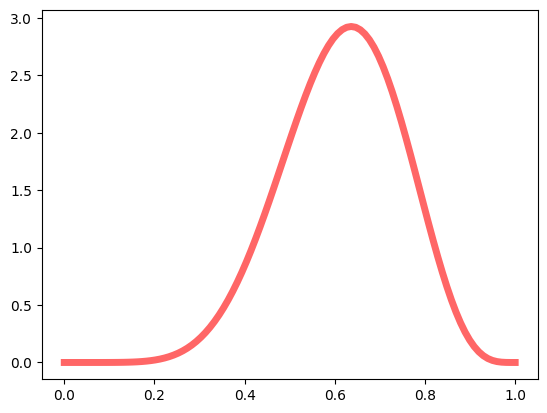

In [22]:
# This code is just so you can see what the beta distribution looks like.
a = 8
b = 5
fig, ax = plt.subplots(1, 1)
x = np.linspace(0,1,100)
ax.plot(x, ss.beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')

Since in regression we typically model the mean as a function of inputs $X$, it is more convenient to parameterize the beta distribution in terms of the mean $\mu \in (0,1)$ and a "concentration" $\phi > 0$, where

$$a = \mu \cdot \phi$$
$$b = (1 - \mu) \cdot \phi$$

Implement the beta **log likelihood** function below, which takes a vector of data $y$, a vector of means $\mu$, and a scalar (single number) concentration $\phi$, and produces the log likelihood of $y$, assuming each element comes from a beta distribution with parameters given by the corresponding element in $\mu$ and concentration $\phi$.

BIG HINT 1: Recall from the notes that the log likelihood of a single observation of a continuous random variable given specified parameters is the log of the probability density function for that random variable evaluated at the observation.

BIG HINT 2: You can find useful helper functions here https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html which you can access in the form 'ss.beta.functionname(...)'

In [23]:
def betaloglik(y,mu,phi):
    #print(f"y,mu,phi: {y},{mu},{phi}")
    # Your code below ================
    a = mu*phi # Get a from mu and phi using the formula
    b = (1-mu)*phi # Get b from mu and phi using the formula
    #print(f"y:{y}, a:{a}, b:{b}")
    #print(f"logprobs: {ss.beta.logpdf(y,a,b)}")
    return ss.beta.logpdf(y, a, b).sum() # Call the special logpdf function. 
    # ================================
    # (Taking log of beta.pdf probably also works fine but will be less precise
    #  than a specially-made function, and may not optimize as well. Full marks though.)
    
# Example:
betaloglik(np.array([0.2,0.3,0.4,0.5,0.6]), np.array([0.2,0.3,0.4,0.5,0.6]), 100)
# should give
# 10.719823849145598

10.719823849145605

---
## Task 1 Part 3 - Regression Negative Log Likelihood ( X / 5 pts )
Now you will define the regression negative log likelihood, where the values for $\mu$ come from regression predictions. This will make it a bit tricky because the function must accept $\phi$ and $b$ together as one parameter so that we can later use the minimize function. Skeleton code and test code is provided to take care of this; just fill in the missing pieces.

In [24]:
def betaregnegloglik(theta,X,y):
    # theta contains phi followed by beta
    phi = theta[0]
    beta = theta[1:]
    # Your code below =======
    mu = predict(X, beta).T # Use our predict function
    print(y.shape, mu.shape, phi.shape)
    return -1*betaloglik(y, mu, phi) # Negate the beta log likelihood
    # =======================

X = np.array([[1,2],[1,3],[1,4]])
b = np.array([[1],[-1]])
y = np.array([[0.2],[0.4],[0.6]])

phi = np.array([[10]]) # Makes phi a 1 by 1 array
testtheta = np.r_[phi,b] # Stack phi on top of b to get theta
betaregnegloglik(testtheta,X,np.array([0.2,0.4,0.6])) # Compute
# Should produce 16.50271105637038 # WRONG. Shape issue.
# Should produce 7.507492549644741

(3,) (1, 3) (1,)


7.507492549644741

---
## Task 1 Part 4 - Maximum Likelihood Beta Regression ( X / 10 pts )

This example comes from the prominent statistical analysis software *stata*. The manual page for beta regression in stata is here:

[ https://www.stata.com/manuals/rbetareg.pdf ]

The following example uses synthetic (i.e. made-up) data about the pass rate at different schools.

The variable to predict is the school-wide pass rate given in the *prate* variable, which must be between 0 and 1.

The predictive variables are *freemeals* which denotes the proportion of students receiving free meals at school, *pdonations* which denotes the level of donations received by the school, and *summer* which indicates whether or not the school puts on a summer instruction program for students.

In [25]:
df = pd.read_stata("sprogram.dta")
df = pd.get_dummies(df, drop_first = True)
df.head()

,freemeals,pdonations,prate,summer_yes
0,0.400399,1.798023,0.841196,1
1,0.189950,1.095856,0.891308,1
2,0.427926,1.197783,0.898432,1
3,0.273827,1.141752,0.858955,1
4,0.423951,2.958525,0.958682,1


Complete the code in the cell below to find the maximum likelihood coefficients for beta regression. Include an intercept. Use the 'Nelder-Mead' method, which does not require a gradient.

In [26]:
# Function definition - 10 pts
def betaregmaximumlikelihood(X,y):
    phistart = np.ones((1,1))
    bstart = np.zeros((X.shape[1],1))
    thetastart = np.r_[phistart, bstart] # Stack one on top of the other
    
    # Your code below ============
    # Call the minimize function, similar to first assignments
    optimization = minimize(betaregnegloglik, x0=thetastart, 
                            args = (X,y), method = 'Nelder-Mead')
    print(f"minimum: {optimization.fun}")
    results = optimization.x # Get the "theta" vector back
    phi = results[0] # phi is first element
    b = results[1:] # b is rest
    # ===========================
    
    return (b,phi)

(n,m) = df.shape
X = np.c_[np.ones((n,1)),df.drop('prate', axis='columns').values]
y = df.prate

betaregmaximumlikelihood(X,y)

# Should produce
# (array([ 1.17499393, -0.45635901,  0.04496522,  0.55600845]), 10.755643379822022)

/tmp/ipykernel_410337/4291316629.py:9: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  optimization = minimize(betaregnegloglik, x0=thetastart,


(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (1000,) ()
(1000,) (100

(array([ 1.17499393, -0.45635901,  0.04496522,  0.55600845]),
 10.755643379822022)

---
## Task 1 Part 5 - Interpreting the Beta Regression Model - (X / 5) pts

Based on the regression coefficients, for each of the input variables in the dataset, explain how a change in its value is associated with a change in the estimated proportion of students who attain a passing grade. (You can just explain the direction of the change rather than the magnitude.)

#### Write your answer below:

When freemeals increases, estimated proportion of those with a passing grade decreases (negative coef)

When pdonations increases estimated proportion of those with a passing grade increases (positive coef)

When summer_yes increases (or when it is 1 compared to when it is 0), estimated proportion of those with a passing grade increases (positive coef.)



In [27]:
df.columns # Did this to remind myself of order.

Index(['freemeals', 'pdonations', 'prate', 'summer_yes'], dtype='object')

---
---
# Task 2 - Classification and Evaluation (X / 40 pts)

## Data set 
The Child Health and Development Studies investigate a range of topics. One study considered all pregnancies between 1960 and 1967 among women in the Kaiser Foundation Health Plan in the San Francisco East Bay area.

The data frame contains the following data, where each row represents a baby:

- bwt: birth weight (ounces)
- gestation: length of pregnancy (days)
- parity: 0 if mom's first baby, 1 if not mom's first baby
- age: mom's age (years)
- height: mom's height (inches)
- weight: mom's weight (pounds)
- smoke: 0 if mom is nonsmoker, 1 if mom is smoker

Note that babies that are born with a gestation of less than 37 weeks (259 days) are considered pre-term and are at a higher risk for health complications.

Overall this task will focus on building a good predictive model whether a baby will be pre-term or not.

In [28]:
# Loads the data set and drops the case number, as well as any Missing observations: 
df = pd.read_csv('babies.csv').drop('case',axis='columns').dropna()

---
## Task 2 Part 1 - Warm up (X / 10 pts)
In the cell below, write code that does the following:
- Prints the number of observations in the dataset
- Prints the number of variables in the dataset (all variables regardless of whether they are a predictor or label or neither)
- Adds a new variable to the dataset called 'preterm' that is 1 if the baby is pre-term and 0 otherwise
- Prints the number of pre-term babies in the dataset
- Prints the first few rows of the dataset

In [29]:
# Warm-up code ==================

# Number of obs
print(df.shape[0])

# Number of vars
print(df.shape[1])

# Add preterm
df['preterm'] = df.gestation.apply(lambda x: 1 if x<259 else 0)

# Num preterms
print(df.preterm.sum())

# First few rows
df.head(3)
# ================================

1174
7
96


,bwt,gestation,parity,age,height,weight,smoke,preterm
0,120,284.0,0,27.0,62.0,100.0,0.0,0
1,113,282.0,0,33.0,64.0,135.0,0.0,0
2,128,279.0,0,28.0,64.0,115.0,1.0,0


---
## Task 2 Part 2 - Logistic Regression Model (X / 5 pts)

Your next task is to build a model that predicts whether a baby will be pre-term or not using the characteristics of the mother (assuming they are measured prior to birth.) In the cell below, estimate a logistic regression model for pre-term status given these characteristics and print out its coefficients and intercept. Do not use a penalty for learning.

In [30]:
# Code for building a logistic regression model

# Your code here =======================
model = LogisticRegression(penalty='none')

#X = df.loc[:, ['parity','age','height','weight','smoke']]
X = df.drop(['preterm','gestation','bwt'], axis='columns').values


y = df.preterm.values

model.fit(X,y)

print(model.coef_)
print(model.intercept_)
# ======================================


# Actual Coefficients: [[-0.35512466  0.00058173 -0.04752664  0.00488872  0.13200691]]
# Actual Intercept: [0.00343994]

[[-0.35512466  0.00058173 -0.04752664  0.00488872  0.13200691]]
[0.00343994]


---
## Task 2 Part 3 - In-sample Evaluation ( X / 5 pts )

In the cell below, compute the accuracy and the AUROC for your classifier using the training data and print these out. Then explain why the observed accuracy is much higher than the AUROC score in this case.

In [31]:
# Code for computing accuracy and AUROC "in-sample", that is, on the training data.
from sklearn.metrics import accuracy_score, roc_auc_score

# Your code =======================
#Label predictions for accuracy
ypred = model.predict(X)
#Probability predictions for AUROC
ypred_prob = model.predict_proba(X)[:,1]

print('Accuracy', accuracy_score(y, ypred))
print('AUROC Score', roc_auc_score(y, ypred_prob))
# ================================

Accuracy 0.9182282793867121
AUROC Score 0.5654520330859616


#### T2P3 Written answer: Explain in this cell why the observed accuracy is much higher than the AUROC score in this case.

# Delete below

This question is ill-defined IMO.  If by "why" they are different you mean "why do they not return the same value" then the answer is because they are different metrics and are computed differently.

If by "why" you mean "what causes the discrepency" then we can note that only 96 of the 1174 observations have a preterm pregnancy, and so simply guessing 0 can yield fairly decent accuracy.

---
## Task 2 Part 4 - Out-of-sample Evaluation ( X / 10 pts )
In the cell below, compute the accuracy and the AUROC for your classifier using 10-fold stratified cross-validation and print these out. Then explain:
 1) Why stratified cross-validation is appropriate for this dataset and
 2) Any differences you see between these CV-based estimates from your in-sample estimates from Part 3.

In [32]:
# Code for computing accuracy using stratified K-fold CV
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

# Delete below
cver = StratifiedKFold(n_splits = 10)
#cver = LeaveOneOut()

accuracy_cv = cross_val_score(model, X, y, scoring = 'accuracy', cv = cver)
auroc_cv = cross_val_score(model, X, y, scoring = 'roc_auc', cv = cver)
#auroc_cv = cross_val_score(model, X, y, scoring = make_scorer(roc_auc_score, needs_proba=True), cv = cver)


print('Accuracy', accuracy_cv.mean())
print('AUROC', auroc_cv.mean())


Accuracy 0.9182384470520064
AUROC 0.513917349332718


#### T2P4 Written answer

1. Explain why stratified cross-validation is appropriate for this dataset

Stratified cross-validation makes sure that there is the same proportion of + and - examples in each fold. This is important with so much imbalance, because k-fold cross validation can create folds by accident that have no + examples.

2. Explain why these estimated values are different from those in Part 3.

These are out-of-sample estimates using cross-validation, rather than in-sample esitmates on the training data. AUROC is probably lower here because in-sample estimates are optimistic. Accuracy is almost exactly the same.

---
## Task 2 Part 5 - Discussing Evaluation ( X / 10 pts )

There are many ways to evaluate a classifier. For each of the four that you just computed, (training accuracy, training AUROC, CV accuracy, CV AUROC) explain in a sentence or two whether it is useful for assessing the generalization performance of your learned model.

#### Written answer: Explain here.

1. Training accuracy - Training accuracy is not very useful because it can be too optimistic as an estimate of generalization error and because there is a big class imbalance.

2. Training AUROC - Training AUROC is better than training accuracy, but it is still an optimistic estimate.

3. CV accuracy - CV accuracy shouldn't be optimistic but it is still not very useful because of the class imbalance.

4. CV AUROC - CV AUROC is the most useful because it is not optimistically biased and is more informative than accuracy when classes are imbalanced.

---
---
# Task 3 - Model Selection, Regularization (X / 30 pts)

In this section we will use the same data but we will predict **birth weight** from the other variables.

---
## Task 3 Part 1 - Linear Regression (X / 5 pts)

In the cell below, provide code to use 10 fold cross-validation to assess the performance of a linear regression model to predict birth weight from the other variables in terms of its root mean squared error.

In [33]:
# Code here for linear model, 10-fold CV.

# Your code =============

linreg_model = LinearRegression()

X = df.loc[:, ['gestation','parity','age','height','weight','smoke']]

y = df.bwt.values

rmse_cv = np.sqrt(-1*cross_val_score(linreg_model, X, y, cv = 10, scoring = 'neg_mean_squared_error'))

rmse_cv.mean()
# =========================

15.856957571456146

---
## Task 3 Part 2 - Linear Regression, Complex Model (X / 5 pts)
Use the following polynomial feature expansion pipeline component, called `preprocess`, to build a linear regression model to predict the birth weight (bwt). Read through the comments to make sure you understand what is happening. You do not need to modify any of this code.

**In the cell after this giant one full of code** provide code to use the preprocessor to build a linear regression model to predict birthweight based on the transformed data, and evaluate it using root mean squared error from 10-fold cross-validation.

In [34]:
# Dummies, dropping the first category
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.impute import SimpleImputer

# Get all predictors
X = df.loc[:, ['gestation','parity','age','height','weight','smoke']]
# Get bwt - target variable
y = df.loc[:, ['bwt']]

# List categorical features (no scaling, no polynomial-ifying)
categorical_features = ['parity','smoke']
# List numeric (continuous) features
numeric_features = [column for column in X.columns if all(cat_var not in column for cat_var in categorical_features)]

# Collect the names of the new features that will be created by the polynomial transformer
numeric_names = PolynomialFeatures(5, include_bias=False).fit(X.loc[:,numeric_features]).get_feature_names(numeric_features)
all_names = numeric_names
# Add on the categorical feature names
all_names.extend(categorical_features)
# This holds all the feature names in the new space
all_names = np.asarray(all_names)

# This transformer will scale, then transform to polynomial features, then re-scale!
# To be applied to continuous variables only.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(5, include_bias=False)),
    ('scaler2', StandardScaler())])

# This transformer pretty much does nothing. It's for the categorical variables.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))])

# Make a column transformer with two transformers, one for numeric and one for categorical.
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# You can now use the "preprocess" transformer in any pipeline you want, worry-free. 
# Always apply it to the original data X.

# Example:
Xtransform = preprocess.fit_transform(X)
Xtransformdf = pd.DataFrame(Xtransform)
Xtransformdf.columns = all_names

/home/alireza/ml/my_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
# The code above may have failed for people with old versions of sklearn - I am not sure
sk.__version__

'1.1.2'

In [36]:
# Code here for higher-dimensional model, 10-fold CV, report RMSE

# If you use a pipeline, it should have just two steps, the preprocess step (defined above) and the regression step.

# Your code ================
linreg_complex = Pipeline([
    ('preprocess', preprocess),
    ('reg', LinearRegression())
])

rmse_cv = np.sqrt(-1*cross_val_score(linreg_complex, X, y, cv = 10, scoring = 'neg_mean_squared_error'))

rmse_cv.mean()
# =========================

25.555292902990807

---
## Task 3 Part 3 - Feature selection with the LASSO ( X / 10pts )

Based on the training set alone, use 10-fold cross-validation to determine the best value for an L1 penalty (i.e., the LASSO.)

Vary the penalty coefficient alpha from 0.1 to 1.0 in 20 steps. Make a scatter plot of the cross-validation-based RMSE against the the LASSO regularization parameter. Print out the regularization parameter value that you think is best, and print out the CV-based root mean squared error associated with that choice.

My chosen regularization value is {'las__alpha': 0.33684210526315794}
My best RMSE score is 15.941184510773942


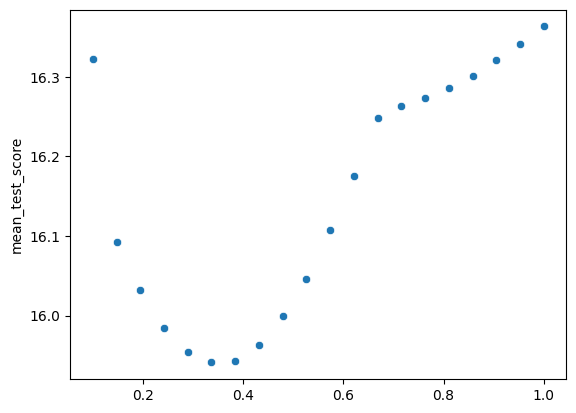

In [37]:
# Code here for LASSO feature selection
from sklearn.linear_model import Lasso
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.model_selection import GridSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Compute scores for different parameter values ========
alpha = np.linspace(0.1,1,20)
param_grid = {'las__alpha': alpha}

lassomodel = Pipeline([
    ('preprocess', preprocess),
    ('las', Lasso(fit_intercept=True))
])

gscv = GridSearchCV(lassomodel, param_grid=param_grid, cv = 10, scoring = 'neg_mean_squared_error')
gscv.fit(X,y);
# ==========================================

# Code to extract and plot lambda values and rmse values =====
cv_results = pd.DataFrame(gscv.cv_results_)
lam = cv_results.param_las__alpha.values
rmse = np.sqrt(-1*cv_results.mean_test_score)
# ==============

# Plot RMSE against regularization parameter (fill in)
myLambdas = lam # Fill in
myRMSEs = rmse # Fill in
sns.scatterplot(x=myLambdas, y=myRMSEs)

# Print out your chosen regularization parameter value (fill in)
mylam = gscv.best_params_ # Fill in
print(f"My chosen regularization value is {mylam}")

# Print out the RMSE for the model with the chosen lambda value (fill in)
myRMSE = np.sqrt(-gscv.best_score_) # Fill in
print(f"My best RMSE score is {myRMSE}")

---
## Task 3 Part 4: Interpreting Results ( X / 5 pts )
Answer the questions in the cells below.

#### How many features (including the intercept) are used in your model from Part 1, Part 2, and by your "best" model from Part 3? If you need to run some code to find this out, you can use the cell below. (3 pts)
1. Number of features in Part 1 model: 7 
2. Number of features in Part 2 model: 128
3. Number of features in best Part 3 model: 28

In [38]:
print(linreg_model.fit(X,y).coef_)
print(gscv.best_estimator_['las'].coef_.shape)
print((gscv.best_estimator_['las'].coef_ != 0).sum())       

[[ 4.71331838e-01 -3.19277171e+00  3.30813654e-03  1.11517625e+00
   4.89389571e-02 -8.15200809e+00]]
(127,)
27


#### Consider the models you built in Part 1, Part 2, and the best model from Part 3. If you had to choose one of these models to deploy, which one would you choose? Explain your answer in 2 or 3 sentences. (2 pts)

I would choose the Part 1 model because its performance is almost identical to the Part 3 model but it has fewer parameters and I think it would be more likely to generalize well.


---
---
---
**You're done! As always, double-check your work by re-running the notebook from scratch.**